Ceci est le premier prototype de mon projet, je n'avais pas bien compris comment utiliser la librairie scanpy. Je pensais au départ que la librairie scanpy était seulement utile pour de l'analyse de données comme PCA , umap , leiden etc. je pensais qu'il fallait structurer en amont le jeu de donnée sans librairie spécifique au RNA single cell

In [1]:
import scanpy as sc
adata = sc.read_h5ad("GSE227828.h5ad")
import pandas as pd
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import anndata

print(adata)

AnnData object with n_obs × n_vars = 10002 × 14139
    obs: 'dataset', 'sample_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'size_factors', 'leiden_res_1'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'leiden_res_1', 'log1p', 'neighbors', 'pca', 'pct_counts_mt', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'log1p_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'


Les  données sont importées 

In [2]:
db_cells_GSM7109167 = pd.read_csv('Input Data/GSM7109167_PT1_barcodes.tsv', sep='\t' , header = None)
db_genes_GSM7109167 = pd.read_csv('Input Data/GSM7109167_PT1_features.tsv', sep='\t' , header = None)
matrix_GSM7109167 = scipy.io.mmread("Input Data/GSM7109167_PT1_matrix.mtx")

db_cells_GSM7109168 = pd.read_csv('Input Data/GSM7109168_PT5_barcodes.tsv', sep='\t' , header = None)
db_genes_GSM7109168 = pd.read_csv('Input Data/GSM7109168_PT5_features.tsv', sep='\t' , header = None)
matrix_GSM7109168 = scipy.io.mmread("Input Data/GSM7109168_PT5_matrix.mtx")


Je ne pense pas qu'il soit utile que je complète la docstrings ici. L'idée est que j'ai crée un dictionnaire contenant le nom des gènes uniques dans le futur dataframe. La difficulté était de lier les index des gènes dans les inputs et le dataframe output. 

In [3]:
def count_gene(i,matrix) : 
    count = 0
    for element in matrix : 
        if element == i : 
            count+=1
            if count >= 400 : 
                return True


def input_for_numpy(data) : 
    db_genes = data[1]
    matrix = data[2]

    gene_all_gene_index_dict = []

    gene_index_dict = {}
    for index ,row in db_genes.iterrows() : # Dans le fichier id , gene , fonction
        gene_index_dict[index] = row[0] # je mets l'index en nom de clé puis je mets le nom du gène à l'intérieur

    gene_all_gene_index_dict.append(gene_index_dict)

    used_genes = {} # dictionnaire avec les gènes qu'ont utilisent 
    value = 0
    for i , j , z in zip(matrix.row , matrix.col , matrix.data) : # j'ouvre le fichier matrix 
        if gene_index_dict[i] not in used_genes : # si l'index (le gène) n'est pas encore présent dans le dictionnaire 
            #if count_gene(i,matrix.row) : 
                used_genes[gene_index_dict[i]] = value # je stock une valeur par ordre d'apparition
                value+= 1

    return used_genes , gene_all_gene_index_dict

def add_cells_to_pre_numpy(data) : 
    global used_gene_global
    global gene_all_gene_index_dict
    dernier_cle , value = list(used_gene_global.items())[-1]
    value+=1
    db_genes = data[1]
    matrix = data[2]

    gene_index_dict = {}
    for index ,row in db_genes.iterrows() : # Dans le fichier id , gene , fonction
        gene_index_dict[index] = row[0] # je mets l'index en nom de clé puis je mets le nom du gène à l'intérieur

    gene_all_gene_index_dict.append(gene_index_dict)

    for i , j , z in zip(matrix.row , matrix.col , matrix.data) : # j'ouvre le fichier matrix 
        if gene_index_dict[i] not in used_gene_global : # si l'index (le gène) n'est pas encore présent dans le dictionnaire 
              #if count_gene(i,matrix.row) : 
                    used_gene_global[gene_index_dict[i]] = value # je stock une valeur par ordre d'apparition
                    value+= 1

def final_numpy() :
    global Liste_all_data 
    global used_gene_global
    global gene_all_gene_index_dict

    Liste_all_cells = []
    nombre_de_colonnes = 0
    comptage_cellule = 0

    for i in range (len(Liste_all_data)) : 
        Liste_all_cells.append([])
        for index ,row in Liste_all_data[i][0].iterrows():
            Liste_all_cells[i].append([row[0],comptage_cellule])
            comptage_cellule+=1
        nombre_de_colonnes+= len(Liste_all_cells[i])

    nombre_de_lignes = len(used_gene_global)
    numpy_final = np.zeros( (nombre_de_lignes,nombre_de_colonnes))
    print(numpy_final.shape)

    for i in range(len(Liste_all_data)) : 
        for gene , cell  , valeur in zip(Liste_all_data[i][2].row , Liste_all_data[i][2].col , Liste_all_data[i][2].data) : # je reparcours ma matrix
             
             numpy_final[used_gene_global[gene_all_gene_index_dict[i][gene]], Liste_all_cells[i][cell][1] ] = valeur # selon l'ordre d'apparition du gène je stock sa valeur 
             if cell >= 1000 :  # car problème de performance de mon pc
                 break


    return numpy_final , Liste_all_cells

def convert_numpy_to_pandas(numpy,Liste_all_cells,Liste_nom) : 
    global used_gene_global

    data_pandas = pd.DataFrame(numpy)
    data_pandas.columns = [f'{Liste_all_cells[i][j][0]}{Liste_nom[i]}'  for i in range (len(Liste_all_cells)) for j in range(len(Liste_all_cells[i]))] # je replace l'index des barcodes au niveau des colonnes
    data_pandas.index = [f'{gene_name}' for gene_name in used_gene_global] 
    return data_pandas

In [4]:

Liste_all_data = [[db_cells_GSM7109167,db_genes_GSM7109167,matrix_GSM7109167] , [db_cells_GSM7109168,db_genes_GSM7109168,matrix_GSM7109168]]
used_gene_global , gene_all_gene_index_dict = input_for_numpy(Liste_all_data[0])
add_cells_to_pre_numpy(Liste_all_data[1])
numpy , Liste_all_cells = final_numpy()
Liste_nom = ["_GSM7109167","_GSM7109168"]
data_pandas = convert_numpy_to_pandas(numpy,Liste_all_cells,Liste_nom)
df_selection = data_pandas.iloc[:, :1000]
df_selection_T = df_selection.T

(25537, 21582)


Le dataframe a été crée , je convertis ce dataframe en h5ad. puis je fais des analyses avec la librairie scanpy. J'ai conscience qu'ici ce n'est pas la méthode optimisé. Le jeu de donnée a été simplifié car mon ordinateur n'est pas assez puisant. En utilisant la librairie scanpy , il est possible de créer le dataframe anndata complet. 

                 genes_name genes_expression
ENSG00000215790    SLC35E2A  Gene Expression
ENSG00000070831       CDC42  Gene Expression
ENSG00000142669    SH3BGRL3  Gene Expression
ENSG00000158161        EYA3  Gene Expression
ENSG00000159023       EPB41  Gene Expression
...                     ...              ...
ENSG00000132688         NES  Gene Expression
ENSG00000154553      PDLIM3  Gene Expression
ENSG00000165566       AMER2  Gene Expression
ENSG00000259212  AC103739.1  Gene Expression
ENSG00000160973       FOXH1  Gene Expression

[25537 rows x 2 columns]


C:\Users\lukyl\AppData\Local\Temp\ipykernel_23880\932494141.py:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_lucas.obs['leiden_res_1'] = adata_lucas.obs['leiden']


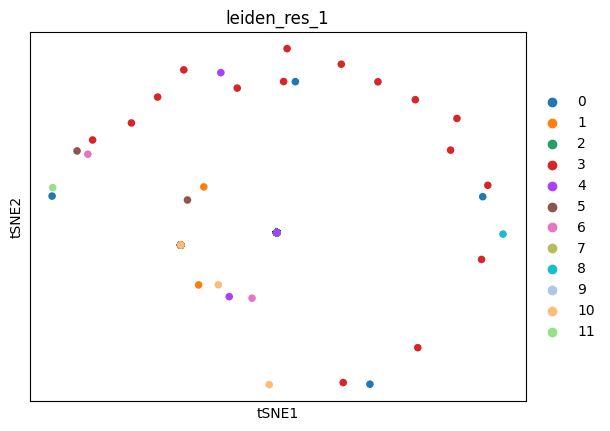

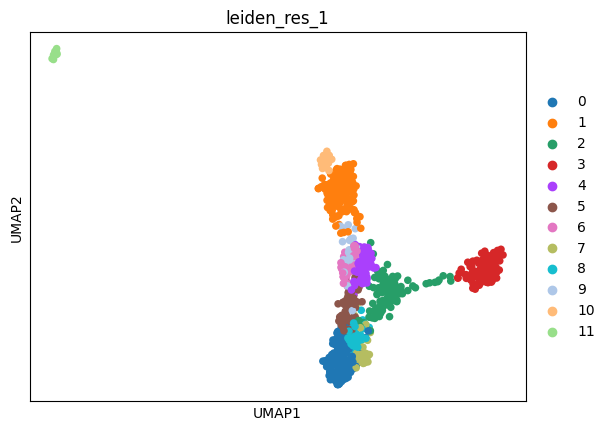

In [6]:
adata_lucas = anndata.AnnData(X=df_selection_T)
sc.pp.pca(adata_lucas, n_comps=50)
sc.pp.neighbors(adata_lucas, n_neighbors=10, use_rep='X_pca')
sc.tl.leiden(adata_lucas, resolution=1.0)
genes_code = []
genes_expression = []
for i in range(len(used_gene_global)) : 
    genes_code.append(None)
    genes_expression.append(None)
for i in range (len(Liste_all_data)) :   
    for index ,row in Liste_all_data[i][1].iterrows() : # Dans le fichier id , gene , fonction
            if row[0] in used_gene_global : 
                genes_code[used_gene_global[row[0]]] = row[1]
                genes_expression[used_gene_global[row[0]]] = row[2]
if None in genes_code :
     print("erreur") 

adata_lucas.var["genes_name"] = genes_code
adata_lucas.var["genes_expression"] = genes_expression
print(adata_lucas.var)
adata_lucas.var['mt'] = adata_lucas.var['genes_name'].str.startswith('MT-')
adata_lucas.var['ribo'] = adata_lucas.var['genes_name'].str.contains('RPS|RPL', regex=True)
adata_lucas.var['hb'] = adata_lucas.var['genes_name'].str.contains('^HB[ABEDGQZ]', regex=True)

sc.pp.calculate_qc_metrics(adata_lucas, qc_vars=['mt', 'ribo', 'hb'], inplace=True)
sc.pp.normalize_total(adata_lucas, target_sum=1e4)  # Normaliser les comptes
sc.pp.log1p(adata_lucas)  # Transformation log1p des données
sc.pp.highly_variable_genes(adata_lucas, flavor='seurat', n_top_genes=20)  # Sélectionner les gènes les plus variables
adata_lucas = adata_lucas[:, adata_lucas.var.highly_variable]  
adata_lucas.obs['leiden_res_1'] = adata_lucas.obs['leiden']
sc.tl.tsne(adata_lucas, n_pcs=50, random_state=42)

# Visualiser les résultats de t-SNE
sc.pl.tsne(adata_lucas, color=['leiden_res_1'], save='_tsne')  # `leiden_res_1` pour colorer les clusters

sc.tl.umap(adata_lucas, n_components=50)

# Visualiser les résultats de UMAP
sc.pl.umap(adata_lucas, color=['leiden_res_1'], save='_umap')  # `leiden_res_1` pour colorer les clusters

J'ai essayé de refaire l'algorithme de la PCA pour me rappeler comment il fonctionne mais encore ici , la librairie sklearn a un algorithme plus optimisé que le mien. 

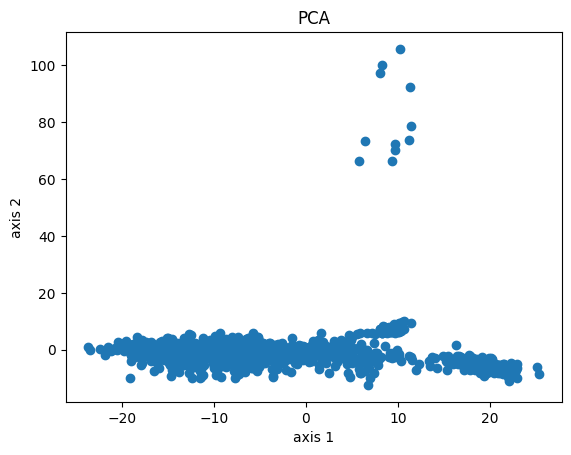

In [7]:
#lignes on a les élèves et en colonnes les variables 
"""
matrix = np.array( [[13.5,15.5,14.5] , [14,11.5,14.1] , [15.3,14,13.7] , [14,13,15] , [13,11,9.5] , 
                  [15,13,12.1] , [14.5,16,9.8], [16.5,17,16.2], [14.8,14,14.7], [13,12.5,8.6]])
"""

def Lucas_PCA_individual_variable(matrix) : 

    matrix_mean = np.mean(matrix , axis = 0)
    matrix_std = np.std(matrix , axis = 0)
    for i in range(len(matrix)) : 
        for j in range(len(matrix[i])) : 
            matrix[i][j] = (matrix[i][j] - matrix_mean[j] ) / matrix_std[j]
    matrix_corr = (matrix.T @ matrix) / len(matrix)

    eigen_values , eigen_vectors = np.linalg.eig(matrix_corr)

    sorted_indices = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_indices]
    sorted_eigenvectors = eigen_vectors[: , sorted_indices]

    pca = matrix @ sorted_eigenvectors


    plt.scatter(pca[:,0] , pca[:,1])
    plt.title("pca")
    plt.xlabel("axis 1")
    plt.ylabel("acis 2")
    plt.axhline(0, color='black',linewidth=0.5)  
    plt.axvline(0, color='black',linewidth=0.5)
    for i, (x, y) in enumerate(zip(pca[:,0], pca[:,1])):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black') 

def Lucas_PCA_variables_individual(matrix) : 
    matrix_mean = np.mean(matrix , axis = 0)
    matrix_std = np.std(matrix , axis = 0)
    for i in range(len(matrix)) : 
        for j in range(len(matrix[i])) : 
            matrix[i][j] = (matrix[i][j] - matrix_mean[j] ) / matrix_std[j]

    matrix_corr = (matrix @ matrix.T) / 10


    eigen_values , eigen_vectors = np.linalg.eig(matrix_corr)

    sorted_indices = np.argsort(eigen_values)[::-1]
    sorted_eigenvalues = eigen_values[sorted_indices]
    sorted_eigenvectors = (eigen_vectors[: , sorted_indices])
    pca = (matrix.T @ sorted_eigenvectors ) / math.sqrt(10)


    plt.scatter(pca[:,0] , pca[:,1])
    plt.title("pca")
    plt.xlabel("axis 1")
    plt.ylabel("acis 2")
    plt.axhline(0, color='black',linewidth=0.5)  
    plt.axvline(0, color='black',linewidth=0.5)
    for i, (x, y) in enumerate(zip(pca[:,0], pca[:,1])):
        plt.text(x, y, str(i), fontsize=9, ha='right', color='black') 


def sklearn_PCA(dataframe) : 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dataframe)
    pca = PCA(n_components=2)
    principal_compo = pca.fit_transform(data_scaled)

    axe_1_2 = pd.DataFrame(principal_compo,columns = ["PC1", "PC2"])
    plt.scatter(axe_1_2["PC1"] , axe_1_2["PC2"])
    plt.xlabel("axis 1")
    plt.ylabel("axis 2")
    plt.title("PCA")
    plt.show()

sklearn_PCA(df_selection_T)

Je ne connaissais pas l'algorithme de Leiden. L'algorithme de Louvain étant similaire à ce dernier, j'ai essayé de le refaire pour comprendre l'algorithme. J'ai encore quelques corrections et d'améliorations à apporter avant qu'il soit terminé.  
Bien que j'arrive à interpréter les résultats de Umap et T-sne, je ne sais pas précisément comment les algorithmes fonctionnent. Ce sera à travailler aussi. 

0.39221938775510207 [[0, 3], [2, 1]] [[14  1  1  4]
 [ 1 16  3  0]
 [ 1  3  2  1]
 [ 4  0  1  4]]
##########################
[[[0, 3], [2, 1]], [[0], [1]]]
#######################
[0.39221938775510207, 0.39221938775510207]


Text(0.5, 1.0, 'Graphe actuel')

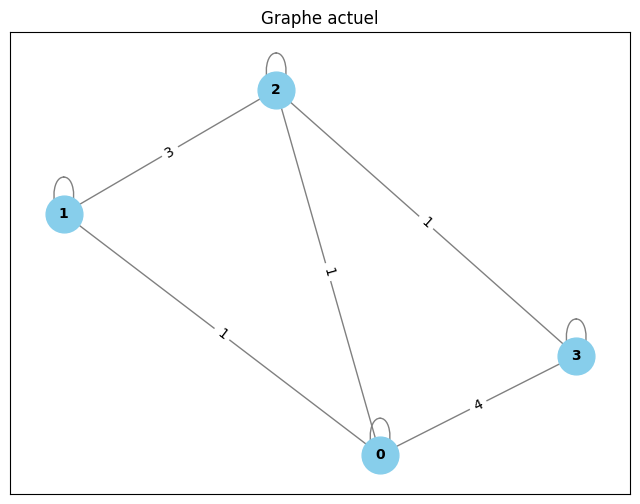

In [9]:


graphe_temoin = np.array( [ [ 14 , 1 , 1 , 4] , [1 , 16 , 3 , 0] ,
                       [1 ,3 , 2 , 1] , [4 , 0 , 1 , 4] ])

"""
graphe_final_test = np.array( [[0,1,0,0,1,0,0,0,0] , 
                             [1,0,1,0,1,0,0,0,0] , 
                             [0,1,0,1,0,0,0,0,0], 
                             [0,0,1,0,1,0,0,0,0] , 
                             [1,1,0,1,0,1,0,0,0], 
                             [0,0,0,0,1,0,1,0,1] , 
                             [0,0,0,0,0,1,0,1,1] , 
                             [0,0,0,0,0,0,1,0,1] , 
                             [0,0,0,0,0,1,1,1,0] ])

"""

def intra_community_compute(community,graphe_test) : 
    sum_intra = 0
    for value in community : 
        for value_2 in community : 
            sum_intra += graphe_test[value_2][value]
    
    sum_inter = 0
    for value in community : 
        sum_inter += np.sum(graphe_test[value])
    return sum_intra , sum_inter

def final_computation(element_compute, m) :
    calcul = 0 
    for element in element_compute : 
        calcul += element[0] - ((element[1])**2 / (2*m))
    calcul = calcul / (2*m)
    return calcul

def calcul_modularité(input_community,graphe_test) : 
    m = 0
    for i in range(len(graphe_test)) : 
        for j in range(len(graphe_test)) : 
            m += graphe_test[i][j]
    m = m / 2
    Liste_compute = []
    for community_element in input_community  : 
        Liste_compute.append(intra_community_compute(community_element,graphe_test))
    resultat = final_computation(Liste_compute , m)
    return resultat

def create_new_community(community,graphe_test) : 
    selected_node = np.random.randint(0, graphe_test.shape[1])
    for index, sublist in enumerate(community):
        if selected_node in sublist: 
            index_community_selected = index
    Liste_possible_target = []
    for i in range(len(graphe_test)) : 
        if graphe_test[selected_node][i] != 0 : 
            if i not in community[index_community_selected] : 
                Liste_possible_target.append(i)
    selected_merge_node = Liste_possible_target[random.randint(0,len(Liste_possible_target)-1)]
    community[index_community_selected].append(selected_merge_node)
    for index , sublist in enumerate(community) :
        if index != index_community_selected :  
            if selected_merge_node in sublist : 
                community[index].remove(selected_merge_node)
                if not sublist : 
                    del community[index]
                    break
def init_community(graph) : 
    Liste_init_community = []
    for i in range(len(graph)) :
        Liste_init_community.append([i])
    return Liste_init_community 

def Louvain_optimization(actual_community,exit_limit_number,graphe_test) : 
    actual_score = calcul_modularité(actual_community,graphe_test)
    new_community = copy.deepcopy(actual_community)
    create_new_community(new_community,graphe_test)
    new_score = calcul_modularité(new_community,graphe_test)
    if actual_score < new_score : 
        exit_limit_number = 0
        resultat  = Louvain_optimization(new_community,exit_limit_number,graphe_test)
        return resultat 
    else : 
        if exit_limit_number >= 10 : 
            return actual_community , actual_score
        else : 
            exit_limit_number += 1
            resultat = Louvain_optimization(actual_community,exit_limit_number,graphe_test)
            return resultat
        
def new_graph(actual_graph,community) : 
    size_graph = len(community)
    new_graph = np.zeros((size_graph,size_graph))

    for i in range(len(community)) : 
        sum = 0
        for value_1 in community[i] : 
            for value_2 in community[i] : 
                sum += actual_graph[value_1,value_2]
        new_graph[i][i] = sum
    for i in range(len(community) - 1) : 
        for j in range( i + 1 , len(community)) : 
            sum = 0
            for element_C1 in community[i] : 
                for element_C2 in community[j] : 
                    sum += actual_graph[element_C1][element_C2]
            new_graph[i][j] = sum
            new_graph[j][i] = sum
    return new_graph

def function_louvain(first_community,exit_limit_number,best_score,graphe_test,previous_com,previous_graph) : 
    resultat = Louvain_optimization(first_community,exit_limit_number,graphe_test)
    simplified_graph = new_graph(graphe_test,resultat[0])
    if not best_score : 
        previous_com = resultat[0]
        stockage_community.append(previous_com)
        stockage_score.append(resultat[1])
        init_new_community = init_community(simplified_graph)
        final_result = function_louvain(init_new_community, exit_limit_number, resultat[1],simplified_graph,previous_com,graphe_test)
        return final_result
    elif resultat[1] <= best_score : 
        stockage_community.append(resultat[0])
        stockage_score.append(resultat[1])
        
        return best_score , previous_com , previous_graph
    elif resultat[1] > best_score : 
        previous_com = resultat[0]
        exit_limit_number = 0
        init_new_community = init_community(simplified_graph)
        final_result = function_louvain( init_new_community, exit_limit_number , resultat[1] , simplified_graph, previous_com , graphe_test)
        
first_community = init_community(graphe_temoin)
exit_limit_number = 0
best_score = None
previous_com = None
previous_graph = None
stockage_community = []
stockage_score = []
score_louvain , community_louvain , graph_louvain = function_louvain(first_community,exit_limit_number,best_score,graphe_temoin,previous_com,previous_graph)


print(score_louvain,community_louvain,graph_louvain)
print("##########################")
print(stockage_community)
print("#######################")
print(stockage_score)


G = nx.Graph()

for i in range(len(graph_louvain)) : 
    for j in range(i , len(graph_louvain)) :
        weight = graph_louvain[i,j]
        if weight > 0 : 
            G.add_edge(i , j , weight = weight)
pos = nx.spring_layout(G)
plt.figure(figsize = (8,6))
nx.draw_networkx(G, pos, with_labels = True , node_size = 700 , node_color = "skyblue", font_size = 10,
        font_weight = "bold" , edge_color = "gray")
labels = nx.get_edge_attributes(G,"weight")
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.title("Graphe actuel")

        